In [104]:
#import from top directory
import sys
sys.path.append('../')

In [105]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
#from src.datasets import get_input_transform, get_collate_fn
from src.datasets import Physionet2012
from src.models import GP_Sig
from src.utils.train_utils import count_parameters
from src.training import TrainingLoop
from exp.callbacks import LogTrainingLoss
from torch.utils.data import DataLoader
import gc
import gpytorch
from src.utils.train_utils import augment_labels

In [106]:
# Parameter for test setting:
data_format  = 'GP'
grid_spacing = 1.
device = 'cpu'


In [107]:
from IPython import embed

"""Module with util functions."""
from functools import partial
import os
from typing import List
import pandas as pd
import numpy as np
import torch
from collections import defaultdict


# Customize input transform for debuggin!
def to_gpytorch_format(d, grid_spacing=1.0):
    """Convert dictionary with data into the gpytorch format.

    Args:
        d: Dictionary with at least the following keys: time, values

    Returns:
        Dictionary where time and values are replaced with inputs, values and
        indices.

    """
    #embed(); print(1)##
    time = d['time']
    del d['time']
    values = d['values']
    valid_indices = np.where(np.isfinite(values))
    #embed(); print(2)##
    inputs = time[valid_indices[0]]
    values_compact = values[valid_indices]
    indexes = valid_indices[1]
    d['inputs'] = inputs
    d['values'] = values_compact
    d['indices'] = indexes[..., np.newaxis]
    #embed(); print(3)##
    # Compute test points
    max_input = np.max(inputs[:, 0])
    min_input = np.min(inputs[:, 0])
    #embed(); print(4)##
    n_tasks = values.shape[-1]
    d['n_tasks'] = n_tasks # is channel_dim
    test_inputs = np.arange(min_input, max_input + grid_spacing, grid_spacing)
    len_test_grid = len(test_inputs)
    test_inputs = np.tile(test_inputs, n_tasks)
    test_indices = np.repeat(np.arange(n_tasks), len_test_grid)
    if n_tasks < 36:
        print(f'n_tasks is {n_tasks} and smaller than 36!')
    #embed(); print(5)##
    d['test_inputs'] = test_inputs[:, np.newaxis].astype(np.float32)
    d['test_indices'] = test_indices[:, np.newaxis].astype(np.int64)
    #embed(); print(6)##
    return d

def get_input_transform(data_format, grid_spacing):
    """
    Util function to return input transform of dataset, depending on data format
    Args:
        - data_format: which data format to use depends on model
            'GP' for models using gpytorch
            'imputed' for imputed baselines
        - grid_spacing: number of hours between each query point / or imputed point depending on format
    """
    if data_format == 'GP':
        input_transform = partial(to_gpytorch_format, grid_spacing=grid_spacing)
        return input_transform
    elif data_format == 'imputed':
        raise NotImplementedError('Pre-Imputed dataset not implemented yet!')
    else:
        raise ValueError('No valid data format provided!')
        


In [151]:
def get_max_shape(l):
    """Get maximum shape for all numpy arrays in list.

    Args:
        l: List of numpy arrays.

    Returns:
        Shape containing the max shape along each axis.

    """
    shapes = np.array([el.shape for el in l])
    return np.max(shapes, axis=0)


def dict_collate_fn(instances, padding_values=None):
    """Collate function for a list of dictionaries.

    Args:
        instances: List of dictionaries with same keys.
        padding_values: Dict with a subset of keys from instances, mapping them
            to the values that should be used for padding. If not defined 0 is
            used.

    Returns:
        Dictionary with instances padded and combined into tensors.

    """
    
    # Convert list of dicts to dict of lists
    dict_of_lists = {
        key: [d[key] for d in instances]
        for key in instances[0].keys() if key != 'n_tasks'
    }
    #print(dict_of_lists.keys())
    n_tasks = instances[0]['n_tasks']

    # Pad instances to max shape
    max_shapes = {
        key: get_max_shape(value) for key, value in dict_of_lists.items()
    }
    #print(max_shapes)
    padded_output = defaultdict(list)
    # Pad with 0 in case not otherwise defined
    padding_values = padding_values if padding_values else {}
    padding_values = defaultdict(lambda: 0., padding_values.items())
    for key, max_shape in max_shapes.items():
        for instance in dict_of_lists[key]:
            #print('key', key)
            #print('shape', instance.shape)
            #print('instance', instance)
            instance_shape = np.array(instance.shape)
            #print(f'Instance shape: {instance_shape}')
            padding_shape = max_shape - instance_shape
            #print(f'Padding shape: {padding_shape}')
            # Numpy wants the padding in the form before, after so we need to
            # prepend zeros
            
            if 'test_' in key:
                #for GP format test inputs, test indices, put padded/invalid points
                #directly in the time series between the channel switches for easier reshaping later 
                to_pad = padding_shape[0] # number of values to pad
                if to_pad > 0: 
                    instance_len = instance_shape[0]
                    #temporarily get rid of extra dim (for GP format):
                    instance = instance[:,0]
                    time_len = int(instance_len/n_tasks) #time_length of valid observation of current instance
                    padding = np.repeat(padding_values[key], to_pad/n_tasks) #as to_pad counts all 
                    #padded values per multi variate time series
                    total_padding = np.repeat(padding, n_tasks)
                    padded_chunk_len = time_len + len(padding) #length of instance time series channel which was padded
                    final_len = len(total_padding) + instance_len
                    #print(f'final_len{final_len}')
                    
                    padded = np.zeros(final_len)
                    for i in np.arange(n_tasks): # for each chunk to be padded
                        instance_part = instance[i*time_len : (i+1)*time_len]
                        padded_chunk = np.concatenate([instance_part, padding])
                        padded[i*padded_chunk_len : (i+1)*padded_chunk_len] = padded_chunk              
                    #add again the additional dim
                    padded = padded[:, np.newaxis]
                    if key == 'test_inputs': #make sure that format is correct
                        padded = padded.astype(np.float32)
                    else:
                        padded = padded.astype(int)
                else:
                    padded = instance
            else:
                #perform standard padding
                padding = np.stack(
                    [np.zeros_like(padding_shape), padding_shape], axis=1)
                padded = np.pad(
                    instance,
                    padding,
                    mode='constant',
                    constant_values=padding_values[key]
                )
            padded_output[key].append(padded)

    # Combine instances into individual arrays
    combined = {
        key: torch.tensor(np.stack(values, axis=0))
        for key, values in padded_output.items()
    }

    return combined

def get_collate_fn(data_format, n_input_dims):
    """
    Util function to retrun collate_fn which might depend on data format / used model
    Args:
        - data_format: which data format to use depends on model
            'GP' for models using gpytorch
            'imputed' for imputed baselines
        - n_input_dims: number of input dims, the gpytorch implementation uses a dummy task for padded
            values in the batch tensor (due to zero indexing it's exactly n_input_dims)
    """
    if data_format == 'GP':
        collate_fn = partial(
            dict_collate_fn,
            padding_values={
                'indices': n_input_dims,
                'test_indices': n_input_dims
            }
        )
        return collate_fn
    elif data_format == 'imputed':
        raise NotImplementedError('Pre-Imputed dataset not implemented yet!')
    else:
        raise ValueError('No valid data format provided!')

In [77]:
#Collate reshape of invalid observations:
x = np.arange(200) # full flat instance
# add additional dim:
time_len  = 10 
channel_dim = int(len(x) / instance_len)

y = -1 # insert value
to_pad = 5 #how many values to insert each time

padding = np.repeat(y, to_pad)
total_padding = np.repeat(padding, channel_dim)
padded_chunk_len = time_len + len(padding)
final_len = len(total_padding) + len(x)

out = np.zeros(final_len)
for i in np.arange(channel_dim): # for each chunk to be padded
    instance_part = x[i*time_len : (i+1)*time_len]
    padded_chunk = np.concatenate([instance_part, padding])
    out[i*padded_chunk_len : (i+1)*padded_chunk_len] = padded_chunk
out


(300,)

In [125]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [72]:
y = -1 # insert value
to_pad = 5 #how many values to insert each time
padding = np.repeat(y, to_pad )
np.concatenate([padding, [3,3]])

array([-1, -1, -1, -1, -1,  3,  3])

In [54]:
np.array(locations).flatten()

array([ 10.,  11.,  12.,  23.,  24.,  25.,  36.,  37.,  38.,  49.,  50.,
        51.,  62.,  63.,  64.,  75.,  76.,  77.,  88.,  89.,  90., 101.,
       102., 103., 114., 115., 116., 127., 128., 129., 140., 141., 142.,
       153., 154., 155., 166., 167., 168., 179., 180., 181., 192., 193.,
       194., 205., 206., 207., 218., 219., 220., 231., 232., 233., 244.,
       245., 246., 257., 258., 259.])

array([0, 1, 2])

In [ ]:
padding_shape = [3,  0]
padding = np.stack(
    [np.zeros_like(padding_shape), padding_shape], axis=1)

## Set up dataset:


In [110]:
#Define dataset transform:
input_transform = get_input_transform(data_format, grid_spacing)
train_dataset = Physionet2012(split = 'training', transform = input_transform)

In [ ]:

dummy_d = Physionet2012(split='training')
dummy_loader = DataLoader(dummy_d, batch_size=16, collate_fn=dict_collate_fn,
                        shuffle=False, pin_memory=True, num_workers=1)

In [ ]:
batch = next(iter(dummy_loader))


In [ ]:
batch['time']

## Customizing Model classes for returning intermediate tensors

In [178]:
# Exact Hadamard Multi-task Gaussian Process Model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, output_device, num_tasks=2, n_devices=1, kernel='rbf'):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.output_device = output_device
        self.mean_module = gpytorch.means.ConstantMean()
        valid_kernels = ['rbf', 'ou']
        if kernel not in valid_kernels:
            raise ValueError(f'parsed kernel: {kernel} not among implemented kernels: {valid_kernels}')
        elif kernel == 'rbf':
            base_covar_module = gpytorch.kernels.RBFKernel()
        elif kernel == 'ou':
            base_covar_module = gpytorch.kernels.MaternKernel(nu=0.5)

        if n_devices > 1: #in multi-gpu setting
            self.covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
            #self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            base_task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)
            self.task_covar_module = gpytorch.kernels.MultiDeviceKernel(
                base_task_covar_module, device_ids=range(n_devices),
                output_device=self.output_device)
        else:
            self.covar_module = base_covar_module #gpytorch.kernels.RBFKernel()
            self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=3)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


# MGP Layer for Neural Network using MultitaskGPModel
class MGP_Layer(MultitaskGPModel):
    def __init__(self,likelihood, num_tasks, n_devices, output_device, kernel):
        super().__init__(None, None, likelihood, output_device, num_tasks, n_devices, kernel)
        #we don't intialize with train data for more flexibility
        likelihood.train()

    def forward(self, inputs, indices):
        return super(MGP_Layer, self).forward(inputs, indices)

    def condition_on_train_data(self, inputs, indices, values):
        self.set_train_data(inputs=(inputs, indices), targets=values, strict=False)
        
# Custom GP Adapter:
# MGP Adapter
class GPAdapter(nn.Module):
    def __init__(self, clf, n_input_dims, n_mc_smps, sampling_type, *gp_params):
        super(GPAdapter, self).__init__()
        self.n_mc_smps = n_mc_smps
        # num_tasks includes dummy task for padedd zeros
        self.n_tasks = gp_params[1] - 1
        self.mgp = MGP_Layer(*gp_params)
        self.clf = clf #(self.n_tasks)
        #more generic would be something like: self.clf = clf(n_input_dims) #e.g. SimpleDeepModel(n_input_dims)
        self.sampling_type = sampling_type # 'monte_carlo', 'moments'

    def forward(self, *data):
        """
        The GP Adapter takes input data as a list of 5 torch tensors (3 for train points, 2 for prediction points)
            - inputs: input points of time grid (batch, timesteps, 1)
            - indices: indices of task or channels (batch, timesteps, 1)
            - values: values (or targets) of actual observations (batch, timesteps)
            - test_inputs: query points in time (batch, timesteps, 1)
            - test_indices: query tasks for given point in time (batch, timesteps, 1)
        """
        self.posterior = self.gp_forward(*data)

        inputs, indices, values, test_inputs, test_indices = data

        #Get regularly-spaced "latent" timee series Z:
        if self.sampling_type == 'monte_carlo':
            #draw sample in MGP format (all tasks in same dimension)
            Z = self.draw_samples(self.posterior, self.n_mc_smps)
        elif self.sampling_type == 'moments':
            #feed moments of GP posterior to classifier (mean, variance)
            Z = self.feed_moments(self.posterior)

        #reshape such that tensor has timesteps and tasks/channels in independent dimensions for Signature network:
        Z, Z_raw = self.channel_reshape(Z)
        #Z, Z_raw = self._channel_reshape(Z, test_indices)
        #Z = self._collapse_tensor(Z)

        return self.clf(Z), Z, Z_raw

    def gp_forward(self, *data):
        #Unpack data:
        inputs, indices, values, test_inputs, test_indices = data

        #Condition MGP on training data:
        self.mgp.condition_on_train_data(inputs, indices, values)

        #Return posterior distribution:
        return self.mgp(test_inputs, test_indices)

    def draw_samples(self, posterior, n_mc_smps):
        #Draw monte carlo samples (with gradient) from posterior:
        return posterior.rsample(torch.Size([n_mc_smps])) #mc_samples form a new (outermost) dimension

    def feed_moments(self, posterior):
        """
        Get mean and variance of posterior and concatenate them along the channel dimension for feeding them to feed the clf
        """
        mean = posterior.mean
        var = posterior.variance
        return torch.cat([ mean, var ], axis=-1) # concat in channel dim
        #return torch.stack([mean, var], axis=0) # stacked in a innermost dim to replace mc_smp dim

    def parameters(self):
        return list(self.mgp.parameters()) + list(self.clf.parameters())

    def train(self, mode=True):
        """
        only set classifier to train mode, MGP always in eval mode for posterior draws
        """
        if mode:
            super().train()
            self.mgp.eval()
        else:
            super().train(False)

    def eval(self):
        """
        eval simply calls eval of super class (which in turn activates train with False)
        """
        super().eval()

    def channel_reshape(self, X):
        """
        reshaping function required as hadamard MGP's output format is not directly compatible with subsequent network
        """
        #first check if we have to doubele the number of channels
        if self.sampling_type == 'moments':
            channel_dim = 2*self.n_tasks
        else:
            channel_dim = self.n_tasks

        X_reshaped = X.view(X.shape[:-1]                    #batch-dim (or mc_smp and batch_dim)
            + torch.Size([channel_dim])                     #channel-dim
            + torch.Size([int(X.shape[-1] / channel_dim)])  #time steps dim
        )
        # finally, swap last two dims: timestep and channel dim for Signature Augmentations
        X_reshaped = X_reshaped.transpose(-2,-1)
        
        if self.sampling_type == 'monte_carlo':
            X_reshaped = X_reshaped.flatten(0,1) #SigNet requires 3 dim setup, so we flatten out the mc dimension with batch
        return X_reshaped, X
    
    def _channel_reshape(self, Z_raw, test_indices):
        channel_dim = self.n_tasks
        stats_dim  = Z_raw.shape[0] #either mc samples or [mean/var] dimension depending on sampling type
        batch_size = Z_raw.shape[1]
        #if self.sampling_type == 'moments':
        #    channel_dim *= 2
        max_len = int(Z_raw.shape[-1] / channel_dim) # max_len of time series in the batch
        #print(f'Z_raw shape {Z_raw.shape}')
        #print(f'channel_dim {channel_dim}')
        #print(f'stats_dim {stats_dim}')
        #print(f'batch_size {batch_size}')
        #print(f'max_len {max_len}')
        #print(f'test_indices shape: {test_indices.shape}')
        
        #initialise resulting tensor:
        Z = torch.zeros([stats_dim, batch_size, max_len, channel_dim])
        for sample in torch.arange(stats_dim):
            for i in torch.arange(batch_size):
                Z_raw_i = Z_raw[sample, i] # GP draw array of instance i, pooling all values in single vector
                test_indices_i = test_indices[i].flatten() # array pointing to index of each value of raw gp output
                # Create output channels:
                for j in torch.arange(channel_dim):
                    z_j = Z_raw_i[test_indices_i == j] #select all (time-ordered) values that belong to task/channel j
                    #print(f'z_j: {z_j}')
                    #print(f'z_j shape: {z_j.shape}')
                    curr_len = z_j.shape[0] 
                    Z[sample, i, :curr_len, j] = z_j
        return Z, Z_raw
    
    def _collapse_tensor(self, X):
        """
        Util function to collapse tensor depending on sampling_type
            - mc samples are joined in batch dimension
            - moments are stacked in channel dimension
        In dimensions:
            [stats_dim, batch, length, channel]
        Out dimension:
            [batch, length, channel]
        """
        if self.sampling_type == 'monte_carlo':
            return X.flatten(0,1) # merge mc_smp and batch dim
        elif self.sampling_type == 'moments':
            #X = X.transpose(0,2).tranpose(0,1)
            X = X.permute(1,2,0,3) 
            return X.flatten(-2,-1) #merge channel and moments dim
    
from src.models.deep_models import DeepSignatureModel

class GP_Sig(nn.Module):
    def __init__(self, n_input_dims, out_dimension, sampling_type, n_mc_smps,
            n_devices, output_device, sig_depth=2, kernel='rbf'):
        super(GP_Sig, self).__init__()

        #safety guard:
        self.sampling_type = sampling_type
        if self.sampling_type == 'moments':
            n_mc_smps = 1
            # the classifier receives mean and variance of GPs posterior
            clf_input_dims = 2*n_input_dims
        else:
            clf_input_dims = n_input_dims

        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(
                        output_device, non_blocking=True)
        clf = DeepSignatureModel(   in_channels=clf_input_dims,
                                    out_dimension=out_dimension,
                                    sig_depth=sig_depth
                                )

        self.model = GPAdapter( clf,
                                None,
                                n_mc_smps,
                                sampling_type,
                                likelihood,
                                n_input_dims + 1,
                                n_devices,
                                output_device,
                                kernel
        )

    def forward(self, *data):
        return self.model(*data)

## Setting up parameters for Model

In [215]:
#Determine number of input dimensions as GP-Sig models requires this parameter for initialisation
n_input_dims = train_dataset.measurement_dims
out_dimension = train_dataset.n_classes
collate_fn = get_collate_fn(data_format, n_input_dims)
sampling_type = 'moments' #'monte_carlo'
n_mc_smps = 3 # for debugging
n_devices = 1
output_device = 'cpu'

## Initialize a standard GP-Sig adapter

In [216]:
model = GP_Sig(n_input_dims, 
               out_dimension, 
               sampling_type, 
               n_mc_smps, 
               n_devices, 
               output_device)
model.to(device)
print(f'Number of trainable Parameters: {count_parameters(model)}')

Number of trainable Parameters: 194900


In [217]:
# Loss function:
loss_fn = torch.nn.BCELoss()

# Parameters for Training Loop

In [218]:
n_epochs = 1
batch_size = 32
learning_rate = 0.001
max_root = 25
weight_decay = 1e-3
callbacks = None
virtual_batch_size = None

In [219]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=False, pin_memory=True, num_workers=8)
n_batches = len(train_loader)
optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=weight_decay)
optimizer.zero_grad()

#d = next(iter(train_loader))
d = next(iter(train_loader)) #[0]
if n_mc_smps > 1:
    y_true = augment_labels(d['label'], n_mc_smps)
else:
    y_true = d['label']
#GP format of data:
inputs = d['inputs']
indices = d['indices']
values = d['values']
test_inputs = d['test_inputs']
test_indices = d['test_indices']

# Set model into training mode and feed forward
model.train()



GP_Sig(
  (model): GPAdapter(
    (mgp): MGP_Layer(
      (likelihood): GaussianLikelihood(
        (quadrature): GaussHermiteQuadrature1D()
        (noise_covar): HomoskedasticNoise(
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (task_covar_module): IndexKernel(
        (raw_var_constraint): Positive()
      )
    )
    (clf): DeepSignatureModel(
      (augment1): Augment(
        activation=<function relu at 0x1202c7440>, include_original=True, include_time=True
        (convs): ModuleList(
          (0): Conv1d(72, 8, kernel_size=(4,), stride=(1,))
          (1): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
          (2): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
        )
      )
      (signature1): Signature(depth=2, stream=True, inverse=False)
      (augment2): Augment(
        activation=<function relu at 0x1202c7440>, 

In [134]:
#float64 before
test_inputs.dtype

torch.float64

In [141]:
x = np.arange(3).astype(np.float32)

In [140]:
torch.tensor(x).dtype

torch.float64

In [220]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(max_root):
    logits, Z, Z_raw = model( inputs,
                    indices,
                    values,
                    test_inputs,
                    test_indices)

In [ ]:
for name, param in model.named_parameters():
    print(name, param)

In [ ]:
model.model.mgp.task_covar_module.covar_factor[36:,:] = torch.zeros(3, requires_grad=False)
model.model.mgp.task_covar_module.raw_var[36:] = torch.zeros(1, requires_grad=False)

## Do one update step:


In [ ]:
y_true = y_true.flatten()
loss = loss_fn(logits, y_true)

# Optimize
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
for name, param in model.model.mgp.named_parameters():
    print(name, param)

In [ ]:
model.model.mgp.task_covar_module.covar_factor

## Plot one instance (Z imputed overlay with Z-raw)

In [240]:
instance = 2 #2
sample = 0

In [226]:
Z_raw.shape, Z.shape, test_inputs.shape

(torch.Size([32, 3528]), torch.Size([32, 49, 72]), torch.Size([32, 1764, 1]))

In [241]:

if sampling_type == 'monte_carlo':
    Z_raw_i = Z_raw[sample, instance].detach().numpy()
    Z_i = Z[instance + batch_size*sample].detach().numpy()
else:
    Z_raw_i = Z_raw[instance].detach().numpy()
    Z_i = Z[instance].detach().numpy()
Z_raw_i.shape, Z_i.shape

((3528,), (49, 72))

In [235]:
Z_raw_i.shape[0]/2

1764.0

In [ ]:
#Z_new_i = Z_new[instance].detach().numpy()
#Z_i = Z[instance].detach().numpy()

In [ ]:
#Z_slow_i = Z_slow[sample, instance].detach().numpy()
#Z_raw_i = Z_raw[sample ,instance].detach().numpy()


In [ ]:
#Z_raw_i.shape, Z_new_i.shape

In [ ]:
#Z[instance + batch_size*0].detach().numpy().shape

In [242]:
test_inputs_i = test_inputs[instance].flatten()
test_indices_i = test_indices[instance].flatten()

In [243]:
max(test_indices_i)

tensor(36)

In [238]:
def plot_channels(channels_raw, channels, Z_i, Z_raw_i,test_indices_i, sampling_type, use_mean=True):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    for j in channels:
        if not use_mean:
            j += 36 #channel_dim, to access other part of tensor
        #after reshaping:
        x3 = Z_i[:,j] 
        ax[0].plot( x3, color='red')
    for j in channels_raw:
        #raw GP
        if sampling_type == 'monte_carlo':
            x_raw = Z_raw_i[test_indices_i == j]
        else:
            Z_raw_mean = Z_raw_i[:1764]
            Z_raw_var = Z_raw_i[1764:]
            if use_mean:
                x_raw = Z_raw_mean[test_indices_i == j]
            else: 
                x_raw = Z_raw_var[test_indices_i == j]
        ax[1].plot( x_raw , color='blue')

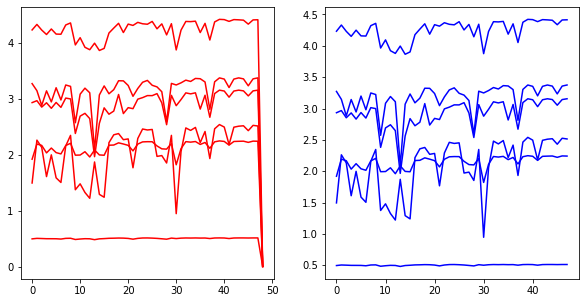

In [246]:
ranges = [6]
channels_raw = np.arange(*ranges)
#channels = np.arange(0,72,2)
channels = np.arange(*ranges)
plot_channels(channels_raw, channels, Z_i, Z_raw_i,test_indices_i,sampling_type, use_mean=False)

In [174]:
inp = Z_raw #_dummy.float()
Z_new = new_reshape(inp,test_indices) #other
Z_new_i = Z_new[0,instance].detach().numpy()

Z_pad, Z_out = pad_reshape(inp,test_indices, padding_value=0)
Z_pad_i = Z_pad[instance].detach().numpy()

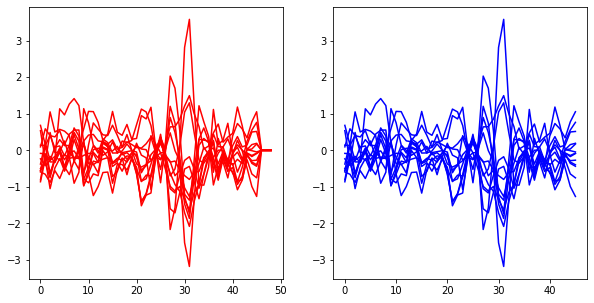

In [176]:
channels_raw = np.arange(*ranges)
#channels = np.arange(0,72,2)
channels = np.arange(*ranges)
plot_channels(channels_raw, channels, Z_new_i, Z_raw_i,test_indices_i)

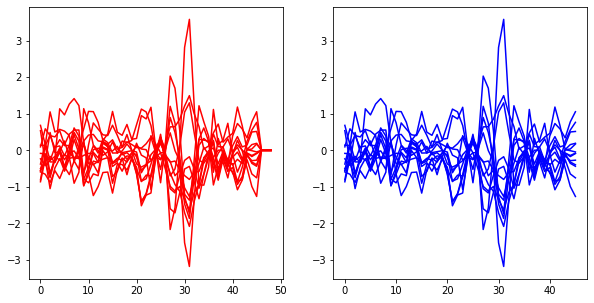

In [177]:
channels_raw = np.arange(*ranges)
#channels = np.arange(0,72,2)
channels = np.arange(*ranges)
plot_channels(channels_raw, channels, Z_pad_i, Z_raw_i,test_indices_i)

In [ ]:
#raw GP draw (Z) channnel j of instance i
j = 4
x_raw = Z_raw_i[test_indices_i == j]
plt.plot( x_raw , color='blue')
#x_raw

#reshaped GP draw of channel j and instance i
x3 = Z_i[:,j+36] 
plt.plot( x3, 'o',color='red')
#x3

In [ ]:
def test_reshape(Z_raw, Z_new, test_indices, batch_size=32, channel_dim=36):
    for i in np.arange(batch_size):
        instance = i
        Z_i = Z_new[instance].detach().numpy()
        Z_raw_i = Z_raw[0,instance].detach().numpy()
        test_indices_i = test_indices[instance].flatten()
        for j in np.arange(channel_dim):
            if not Z_raw_i[test_indices_i == j] == Z_i[:,j]):
                print(f'{Z_raw_i[test_indices_i == j]} and {Z_i[:,j]} not the same')    

In [ ]:
test_reshape(Z_raw, Z_new, test_indices)

In [161]:
def new_reshape(Z_raw, test_indices, channel_dim = 36, padding_value=0, sampling_type='monte_carlo'):
    #if sampling_type == 'moments':
    #    #for consistency, transiently add mc_smp dimension:    
    stats_dim  = Z_raw.shape[0] #either mc samples or [mean/var] dimension depending on sampling type
    batch_size = Z_raw.shape[1]
    max_len = int(Z_raw.shape[-1] / channel_dim) # max_len of time series in the batch
    
    #initialise resulting tensor:
    Z = torch.zeros([stats_dim, batch_size, max_len, channel_dim])
    for sample in torch.arange(stats_dim):
        for i in torch.arange(batch_size):
            #print(f'SAMPLE {i}')
            #TODO adjust for multiple mc_smps!
            Z_raw_i = Z_raw[sample, i] # GP draw array of instance i, pooling all values in single vector
            test_indices_i = test_indices[i].flatten() # array pointing to index of each value of raw gp output
            #test_inputs_i = test_inputs[i].flatten() # array pointing to time input of each value of raw gp output

            # Create output channels:
            for j in torch.arange(channel_dim):
                z_j = Z_raw_i[test_indices_i == j] #select all (time-ordered) values that belong to task/channel j
                curr_len = z_j.shape[0] 
                Z[sample, i, :curr_len, j] = z_j
    return Z
            
def other_reshape(Z_raw, test_indices, test_inputs, channel_dim=36, padding_value=0):
    Z_raw = Z_raw[0]
    batch_size = Z_raw.shape[0]
    max_len = int(Z_raw.shape[-1] / channel_dim)
    Z = torch.zeros([batch_size, max_len, channel_dim])
    instance_ids = torch.repeat_interleave(torch.arange(batch_size, dtype=int), max_len*channel_dim)
    channel_ids = torch.repeat_interleave(torch.arange(channel_dim, dtype=int), max_len).repeat(batch_size)
    time_ids = torch.arange(max_len, dtype=int).repeat(channel_dim).repeat(batch_size)
    Z[(instance_ids, time_ids, channel_ids)] = Z_raw.flatten()
    return Z

In [162]:
def pad_reshape(Z_raw, test_indices, channel_dim=36, padding_value=0.):
    Z_raw = Z_raw[0]
    batch_size = Z_raw.shape[0]
    max_len = int(Z_raw.shape[-1] / channel_dim)
    Z = torch.zeros([batch_size, max_len, channel_dim])
    
    #as flattening goes along dimensions from outside to inside [0, 1, 2, ..], first permute axis:
    #Z_raw = Z_raw.permute(1,0) #now, first dim is 1764 (tasks and timesteps collapsed), second is batch

    instance_ids = torch.repeat_interleave(torch.arange(batch_size, dtype=int), max_len*channel_dim)
    #array of each (max_len * channel_dim) batch_id: so [0,0,0 .. (1764 times), 1,1,1 ... (...) ... ,32 ,32 ,32]
    
    channel_ids = torch.repeat_interleave(torch.arange(channel_dim, dtype=int), max_len).repeat(batch_size)
    #array of of each max_len times channel 0, .. channel 1, .. . this repeated batch_size times
    
    time_ids = torch.arange(max_len, dtype=int).repeat(channel_dim).repeat(batch_size)
    
    #before applying the indices, first MASK the invalid ones!
    #test_indices_t = test_indices.permute(1,0,2)
    test_indices_t = test_indices.squeeze(-1) # now format [channel*max_len, batch] which corresponds to Z_raw
    
    #valid_mask = [test_indices_t.flatten() != channel_dim]   
    #Z[(instance_ids[valid_mask], time_ids[valid_mask], channel_ids[valid_mask])] = Z_raw.flatten()[valid_mask]
    #return Z

    #Alternative with inplace masking of invalid points (batch padded) 
    invalid_mask = [test_indices_t.flatten() == channel_dim]
    Z_out = Z_raw.flatten()
    Z_out[invalid_mask] = padding_value
    Z[(instance_ids, time_ids, channel_ids)] = Z_out
    return Z, Z_out

In [ ]:
Z_new = new_reshape(Z_raw,test_indices) #other_reshape(Z_raw,test_indices, test_inputs)

In [ ]:
test_ind_new = torch.cat([test_indices, test_indices], axis=1)

In [ ]:
Z_pad = pad_reshape(Z_raw,test_indices, padding_value=0)

In [ ]:
Z_raw_dummy = torch.arange(32*1764).reshape(1,32,1764)

In [ ]:
(test_indices[7] == 36).sum()

In [ ]:
#Remove redundant dim:
Z_raw_original = Z_raw[0]
test_inputs_original = test_inputs.squeeze(-1)
test_indices_original = test_indices.squeeze(-1)

In [ ]:
plt.plot(test_indices_original.flatten())

In [ ]:
i = 2
test_indices_original_i = test_indices_original[i]
plt.plot(test_indices_original_i)
test_indices_original_i[-1]
test_indices_original_i[:50]

In [ ]:
# Setting up test / dummy data for simplifying problem:
batch_size = 10 # sample 2 has one padded step
max_len = 3
channel_dim = 4



In [ ]:
test_indices_dummy = torch.zeros(3,4)

In [ ]:
test_indices_dummy[0,-1] = 1.

In [ ]:
plt.plot(test_indices[0])

In [ ]:
test_indices_t = test_indices.permute(1,0,2)
test_indices_t = test_indices_t.squeeze(-1)
valid_mask = [test_indices_t.flatten() != channel_dim]

In [ ]:
Z_raw_prob = Z_raw[0][2].detach().numpy()
Z_prob = Z[2][:,0].detach().numpy()

In [ ]:
zeros = np.where(test_ind_prob == 24)

In [ ]:
zeros

In [ ]:
test_ind_prob = test_indices[2].flatten().numpy()

In [ ]:
plt.plot(Z_raw_prob[test_ind_prob == 0])

In [ ]:
plt.plot(Z_prob)

In [ ]:
invalids = np.where(test_ind_prob == 36)[0]

In [ ]:
plt.plot(Z_prob[invalids])

In [ ]:
(Z_pad == 0).sum() # we have zeros, as opposed to other_reshape.. but where are they?

In [ ]:
(Z_raw.detach().numpy() == 0).sum()

In [ ]:
Z_pad_i

In [ ]:
plt.plot(Z_pad_i.flatten()[:], '-o')
Z_pad_i.flatten()[503]

In [ ]:
plt.plot(Z_new_i.flatten()[:], '-o')
Z_new_i.flatten()[503]

In [ ]:
plt.plot(Z_new[0,0,:,35])

In [ ]:
plt.plot(Z_pad[0,:,35])

In [ ]:
plt.plot(Z_new_i.flatten()[1726:2100], '-o')
Z_new_i.flatten()[1728]

In [ ]:
test_indices_i = test_indices[instance].flatten()

In [ ]:
torch.where(test_indices_i == 36)

In [ ]:
x = torch.arange(24).reshape(4,6)

In [ ]:
x.flatten()

In [ ]:
plt.plot(Z.flatten()==0)

In [ ]:
Z_pad.flatten().detach().numpy()==0

In [ ]:
(Z_new == 0).sum()

In [ ]:
(test_indices_t.flatten() == channel_dim).sum()

In [ ]:
a = torch.zeros([3,3])
b = torch.ones([3,3])
c = torch.stack([a,b], axis=0)

In [ ]:
x = torch.arange(24).reshape(2,3,4)

In [ ]:
plt.plot(test_indices.flatten().numpy())

In [ ]:
test_indices_t = test_indices.permute(1,0,2)

In [ ]:
test_indices_t = test_indices_t.squeeze(-1) 

In [ ]:
test_indices_t.flatten()

In [ ]:
[test_indices_t.flatten() != channel_dim]

In [ ]:
Z_test = Z_raw[0]
Z_test_p = Z_test.permute(1,0)

In [ ]:
Z_test.shape, Z_test_p.shape


In [ ]:
Z_slow = new_reshape(Z_raw, test_indices, channel_dim = 72, sampling_type='moments') #36

In [ ]:
Z_slow.transpose(0,1).transpose(0,2).shape

In [ ]:
channel_ids[:49+1]
#plt.plot(channel_ids.numpy())


In [ ]:
samp = 0
plt.plot(test_indices[samp].numpy()) 
print(test_indices[samp].numpy().max())

In [ ]:
test_inputs[0].flatten()[:200]

In [ ]:
plt.plot(time_ids[:200])

In [ ]:
batch_size=32; channel_dim=36; max_len = int(Z_raw.shape[-1] / channel_dim)
instance_ids = torch.repeat_interleave(torch.arange(batch_size, dtype=int), max_len*channel_dim)
channel_ids = torch.repeat_interleave(torch.arange(channel_dim, dtype=int), max_len).repeat(batch_size)
time_ids = torch.arange(max_len, dtype=int).repeat(channel_dim).repeat(batch_size)

In [ ]:
pos = 3
print( instance_ids[pos], time_ids[pos], channel_ids[pos] )


In [ ]:
plt.plot(channel_ids.numpy()[:200]) 


In [ ]:
plt.plot( test_indices[0].flatten()[:200])

In [ ]:
new_reshape(Z_raw, test_indices, test_inputs)

In [ ]:
#Get instance i
test_inputs_first = test_inputs[instance].flatten()
test_indices_first = test_indices[instance].flatten()
inputs_first = inputs[instance].flatten()
indices_first = indices[instance].flatten()
values_first = values[instance]

In [ ]:
def plot_instance(instance, Z, Z_raw, test_inputs, 
                  test_indices, inputs, indices, 
                  values, show_channels='all', show_type=['gp', 'gp_reshaped', 'input'], 
                 n_mc_smps=1, batch_size=32):
    """
    Plot GP posterior sample of patient
    - Z_raw: posterior draw (in raw format before reshaping for clf)
    - test_inputs: (time grid to query the GP)
    - test_indices: tasks indices to query the GP
    """
    test_inputs_i = test_inputs[instance].flatten() # query grid points 
    test_indices_i = test_indices[instance].flatten() # query task indices
    inputs_i = inputs[instance].flatten() # training time points
    indices_i = indices[instance].flatten() # training task indices
    values_i = values[instance] # training y values

    if show_channels == 'all':
        show_channels = np.unique(test_indices_i)
        n_channels = len(show_channels)
    else:
        n_channels = len(show_channels)
    fig, ax = plt.subplots(nrows=n_channels, figsize=(5*n_channels, 4*n_channels))

    for sample in np.arange(n_mc_smps):
        #first extract data of instance:
        Z_i = Z[instance + batch_size*sample]
        Z_i = Z_i.detach().numpy() #reshaped GP draw
        Z_raw_i = Z_raw[sample,instance] #raw GP draw
        Z_raw_i = Z_raw_i.detach().numpy()

        for i, channel in enumerate(show_channels):
            if sample == 0:
                if 'input' in show_type:
                    plot_channel(ax[i], values_i, inputs_i, indices_i, channel, color='darkblue')
            if 'gp' in show_type:
                plot_channel(ax[i], Z_raw_i, test_inputs_i, test_indices_i, channel)
            if 'gp_reshaped' in show_type:
                plot_reshaped_channel(ax[i], Z_i, test_inputs_i, channel, color='green')

In [ ]:
def plot_channel(ax, Z_raw, test_inputs, test_indices, channel, color='red'):
    x = test_inputs[test_indices == channel]
    y = Z_raw[test_indices == channel]
    ax.plot(x,y, '-o', color=color)
    ax.set_xlabel(f'Channel {channel}')

In [ ]:
def plot_reshaped_channel(ax, Z, test_inputs, channel, color='green'):
    x = np.unique(test_inputs)
    #x = test_inputs
    print(x.shape)
    print(f'Z shape in plot reshaped: {Z.shape}')
    y = Z[:,channel]
    if y.shape[0] > x.shape[0]:
        diff = y.shape[0] - x.shape[0]
        x = np.pad(x, (0, diff))
    print(y.shape)
    ax.plot(x,y, 'o', color=color)
    #ax.plot(y, '-o', color=color)

In [ ]:
plot_instance(6, Z, Z_raw, test_inputs, 
              test_indices, inputs, indices, 
              values, show_channels=[14, 23], 
              show_type=['input', 'gp'],
              n_mc_smps=n_mc_smps,
              batch_size=batch_size)

In [ ]:
plot_instance(6, Z, Z_raw, test_inputs, 
              test_indices, inputs, indices, 
              values, show_channels=[14, 23], 
              show_type=['input', 'gp_reshaped'],
              n_mc_smps=n_mc_smps,
              batch_size=batch_size)

In [ ]:
x = np.arange(10)
np.pad(x,(0,2))

In [ ]:
plot_instance(0, Z, Z_raw, test_inputs, 
              test_indices, inputs, indices, 
              values, show_channels=[14,21], #[14, 36] 
              show_type=['input', 'gp_reshaped'],
              n_mc_smps=n_mc_smps,
              batch_size=batch_size)

In [ ]:
np.unique(test_inputs_first)

In [ ]:
plot_instance(Z_raw_first, 
              test_inputs_first, 
              test_indices_first, 
              show_channels='all')

In [ ]:
test_indices_first == channel

In [ ]:
Z_raw_first.shape

In [ ]:
# Custom TrainingLoop:
"""Training classes."""
import gc
import gpytorch
import torch
from torch.utils.data import DataLoader
import numpy as np
from src.utils.train_utils import augment_labels


class CustomTrainingLoop():
    """Training a model using a dataset."""

    def __init__(self, model, dataset, data_format, loss_fn, collate_fn, n_epochs, batch_size, virtual_batch_size, learning_rate,
                 n_mc_smps=1, max_root=25, weight_decay=1e-5, device='cuda', callbacks=None):
        """Training of a model using a dataset and the defined callbacks.

        Args:
            model: GP_Sig, competitor
            dataset: Dataset
            n_epochs: Number of epochs to train
            batch_size: Batch size
            learning_rate: Learning rate
            callbacks: List of callbacks
        """
        self.model = model
        self.dataset = dataset
        self.data_format = data_format
        self.loss_fn = loss_fn
        self.collate_fn = collate_fn
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.learning_rate = learning_rate
        self.n_mc_smps = n_mc_smps
        self.max_root = max_root
        self.weight_decay = weight_decay
        self.device = device
        self.callbacks = callbacks if callbacks else []

    def _execute_callbacks(self, hook, local_variables):
        stop = False
        for callback in self.callbacks:
            # Convert return value to bool --> if callback doesn't return
            # anything we interpret it as False
            stop |= bool(getattr(callback, hook)(**local_variables))
        return stop

    def on_epoch_begin(self, local_variables):
        """Call callbacks before an epoch begins."""
        return self._execute_callbacks('on_epoch_begin', local_variables)

    def on_epoch_end(self, local_variables):
        """Call callbacks after an epoch is finished."""
        return self._execute_callbacks('on_epoch_end', local_variables)
    
    def on_batch_begin(self, local_variables):
        """Call callbacks before a batch is being processed."""
        self._execute_callbacks('on_batch_begin', local_variables)

    def on_batch_end(self, local_variables):
        """Call callbacks after a batch has be processed."""
        self._execute_callbacks('on_batch_end', local_variables)

    def on_train_end(self, local_variables):
        """Call callbacks after training is finished."""
        self._execute_callbacks('on_train_end', local_variables)

    # pylint: disable=W0641
    def __call__(self):
        """Execute the training loop."""
        model = self.model
        dataset = self.dataset
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        virtual_batch_size = self.virtual_batch_size
        if virtual_batch_size is not None:
            virtual_scaling = virtual_batch_size / batch_size
            if virtual_batch_size == batch_size: #if virtual batch_size is 'inactive' / same as bs, set it to None
                virtual_batch_size = None
        learning_rate = self.learning_rate
        n_mc_smps = self.n_mc_smps
        collate_fn = self.collate_fn

        n_instances = len(dataset)
        train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn,
                                  shuffle=True, pin_memory=True, num_workers=8) #drop_last=True)
        n_batches = len(train_loader)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate,
            weight_decay=self.weight_decay)

        epoch = 1
        for epoch in range(1, n_epochs+1):
            if self.on_epoch_begin(remove_self(locals())):
                break
            optimizer.zero_grad()
            for batch, d in enumerate(train_loader):
                #if we use mc sampling, expand labels to match multiple predictions
                if n_mc_smps > 1:
                    y_true = augment_labels(d['label'], n_mc_smps)
                else:
                    y_true = d['label']

                if self.data_format == 'GP':
                    #GP format of data:
                    inputs = d['inputs']
                    indices = d['indices']
                    values = d['values']
                    test_inputs = d['test_inputs']
                    test_indices = d['test_indices']

                    if self.device == 'cuda':
                        inputs  = inputs.cuda(non_blocking = True)
                        indices = indices.cuda(non_blocking = True)
                        values  = values.cuda(non_blocking = True)
                        test_inputs = test_inputs.cuda(non_blocking = True)
                        test_indices = test_indices.cuda(non_blocking = True)
                else:
                    raise NotImplementedError('Trainloop for other data formats not implemented yet.')

                self.on_batch_begin(remove_self(locals()))

                # Set model into training mode and feed forward
                model.train()

                if self.data_format == 'GP':
                    with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(self.max_root):
                        logits = model( inputs,
                                        indices,
                                        values,
                                        test_inputs,
                                        test_indices)

                #Compute Loss:
                if self.device == 'cuda':
                    y_true = y_true.flatten().cuda(non_blocking=True)
                else:
                    y_true = y_true.flatten()

                loss = self.loss_fn(logits, y_true)

                if virtual_batch_size is not None:
                    if (batch + 1) % virtual_scaling == 0:
                        # Optimize
                        optimizer.step()
                        optimizer.zero_grad()
                        # Call callbacks
                        self.on_batch_end(remove_self(locals()))
                    loss = loss / virtual_scaling
                    loss.backward()

                else:
                    # Optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Call callbacks
                    self.on_batch_end(remove_self(locals()))
                
                # Clean memory
                torch.cuda.empty_cache()
                gc.collect()

            if self.on_epoch_end(remove_self(locals())):
                break
        self.on_train_end(remove_self(locals()))
